In [2]:
# Instalación de dependencias
%pip install pandas numpy matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


# Introducción
Este notebook documenta la aplicación de la metodología CRISP-DM para comprender el perfil del cliente de Peru_bike, generar conocimiento accionable y apoyar decisiones basadas en datos. A lo largo de las celdas se detalla cada fase del ciclo de vida, desde la comprensión del negocio hasta la construcción del modelo de scoring.

# Equipo y roles
- **Business Project Sponsor:** _(Completar nombre)_ – Define objetivos y valida impacto de negocio.
- **Data Scientist:** _(Completar nombre)_ – Diseña experimentos analíticos y construye el modelo de scoring.
- **Data Engineer:** _(Completar nombre)_ – Gestiona la ingesta, limpieza y versionado de datos.
- **Data Analyst:** _(Completar nombre)_ – Genera insights descriptivos, visualizaciones y conclusiones para los stakeholders.

# Guía de lectura CRISP-DM
Cada bloque de código corresponde a una fase de CRISP-DM: comprensión del negocio, comprensión de los datos, preparación, modelado y conclusiones preliminares. Completar este notebook facilita construir el informe PDF requerido.

In [ ]:
# TF_data.py
# Proyecto Bike Buyers - CRISP-DM completo en un solo archivo

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tkinter import Tk, filedialog

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# 1. CARGA INTERACTIVA DEL CSV
REPO_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
DATA_DIR = REPO_ROOT / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)
RAW_DATA_CANDIDATES = [DATA_DIR / "bike_buyers.csv", REPO_ROOT / "data.csv"]
CLEAN_DATA_PATH = DATA_DIR / "bike_buyers_clean.csv"

def cargar_csv_interactivo():
    """
    Carga el dataset bike_buyers.csv intentando primero las rutas versionadas en el repositorio.
    Si no se encuentra el archivo, abre un diálogo interactivo para seleccionarlo manualmente.
    """
    for candidate in RAW_DATA_CANDIDATES:
        if candidate.exists():
            print(f"\n✅ Archivo cargado automáticamente: {candidate}\n")
            df_loaded = pd.read_csv(candidate)
            if candidate != RAW_DATA_CANDIDATES[0]:
                df_loaded.to_csv(RAW_DATA_CANDIDATES[0], index=False)
                print(f"📁 Copia del dataset original guardada en {RAW_DATA_CANDIDATES[0]}")
            return df_loaded

    print("Se abrirá una ventana para que elijas el archivo bike_buyers.csv...")
    root = Tk()
    root.withdraw()  # Oculta la ventana principal
    root.attributes("-topmost", True)  # La pone delante de todo

    ruta = filedialog.askopenfilename(
        title="Selecciona el archivo bike_buyers.csv",
        filetypes=[("CSV files", "*.csv"), ("Todos los archivos", "*.*")]
    )

    root.destroy()

    if not ruta:
        raise SystemExit("❌ No seleccionaste ningún archivo. Vuelve a ejecutar el programa.")

    print(f"\n✅ Archivo seleccionado: {ruta}\n")
    df_loaded = pd.read_csv(ruta)
    df_loaded.to_csv(RAW_DATA_CANDIDATES[0], index=False)
    print(f"📁 Dataset versionado en: {RAW_DATA_CANDIDATES[0]}")
    return df_loaded

df = cargar_csv_interactivo()

In [ ]:
# 2. CARGAR Y LIMPIAR DATA
print("Primeras filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
df.info()
print("\nTamaño del dataset:", df.shape)

missing_summary = df.isna().sum().sort_values(ascending=False)
print("\nValores nulos por columna:")
print(missing_summary[missing_summary > 0] if missing_summary.any() else "No se encontraron nulos.")

duplicate_count = df.duplicated().sum()
print(f"\nRegistros duplicados detectados: {duplicate_count}")

numeric_summary = df.select_dtypes(include=[np.number]).describe().T
print("\nEstadísticos descriptivos de variables numéricas:")
print(numeric_summary)

# Eliminamos filas con nulos cuando existen y generamos un dataset limpio versionado
df_clean = df.dropna().copy()
print("\nTamaño después de dropna():", df_clean.shape)

df_clean.to_csv(CLEAN_DATA_PATH, index=False)
print(f"\n📁 Dataset limpio guardado en: {CLEAN_DATA_PATH}")

Primeras filas del dataset:
      ID Marital Status  Gender   Income  Children        Education  \
0  12496        Married  Female  40000.0       1.0        Bachelors   
1  24107        Married    Male  30000.0       3.0  Partial College   
2  14177        Married    Male  80000.0       5.0  Partial College   
3  24381         Single     NaN  70000.0       0.0        Bachelors   
4  25597         Single    Male  30000.0       0.0        Bachelors   

       Occupation Home Owner  Cars Commute Distance   Region   Age  \
0  Skilled Manual        Yes   0.0        0-1 Miles   Europe  42.0   
1        Clerical        Yes   1.0        0-1 Miles   Europe  43.0   
2    Professional         No   2.0        2-5 Miles   Europe  60.0   
3    Professional        Yes   1.0       5-10 Miles  Pacific  41.0   
4        Clerical         No   0.0        0-1 Miles   Europe  36.0   

  Purchased Bike  
0             No  
1             No  
2             No  
3            Yes  
4            Yes  

Tamaño de

In [ ]:
# 3. NUEVAS VARIABLES
df_clean["Con_hijos"] = np.where(df_clean["Children"] > 0, "Si", "No")
df_clean["Con_vehiculo"] = np.where(df_clean["Cars"] > 0, "Si", "No")
print("Columnas derivadas creadas: Con_hijos, Con_vehiculo")

print("\nFrecuencia Con_hijos:")
print(df_clean["Con_hijos"].value_counts())
print("\nFrecuencia Con_vehiculo:")
print(df_clean["Con_vehiculo"].value_counts())


Frecuencia Con_hijos:
Con_hijos
Si    688
No    264
Name: count, dtype: int64

Frecuencia Con_vehiculo:
Con_vehiculo
Si    726
No    226
Name: count, dtype: int64


In [ ]:
# 3a. CONTROL DE CALIDAD (OUTLIERS)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
outlier_report = []
for col in numeric_cols:
    q1_val = df_clean[col].quantile(0.25)
    q3_val = df_clean[col].quantile(0.75)
    iqr = q3_val - q1_val
    lower_bound = q1_val - 1.5 * iqr
    upper_bound = q3_val + 1.5 * iqr
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_report.append({
        "variable": col,
        "outliers": len(outliers),
        "porcentaje": (len(outliers) / len(df_clean) * 100) if len(df_clean) else 0
    })

print("\nResumen de posibles outliers (criterio IQR 1.5):")
for item in outlier_report:
    print(f"- {item['variable']}: {item['outliers']} registros ({item['porcentaje']:.2f}% del total)")
print("\nNo se eliminan outliers automáticamente; su tratamiento dependerá del análisis de negocio.")


PREGUNTA 1: Promedio de ingresos según si compró bicicleta
Purchased Bike
No     54455.645161
Yes    57478.070175
Name: Income, dtype: float64

PREGUNTA 2: Promedio de ingresos según estado civil
Marital Status
Married    58359.073359
Single     52972.350230
Name: Income, dtype: float64

PREGUNTA 3: Promedio de hijos según nivel educativo (solo con hijos)
Education
Bachelors              2.528634
Graduate Degree        2.689076
High School            2.768595
Partial College        2.577778
Partial High School    2.780488
Name: Children, dtype: float64

PREGUNTA 4: Promedio de vehículos según ocupación (solo con vehículo)
Occupation
Clerical          1.489583
Management        2.335526
Manual            1.445783
Professional      2.123810
Skilled Manual    1.724324
Name: Cars, dtype: float64

PREGUNTA 5: Promedio de edad según si es propietario de vivienda
Home Owner
No     42.393333
Yes    45.113497
Name: Age, dtype: float64


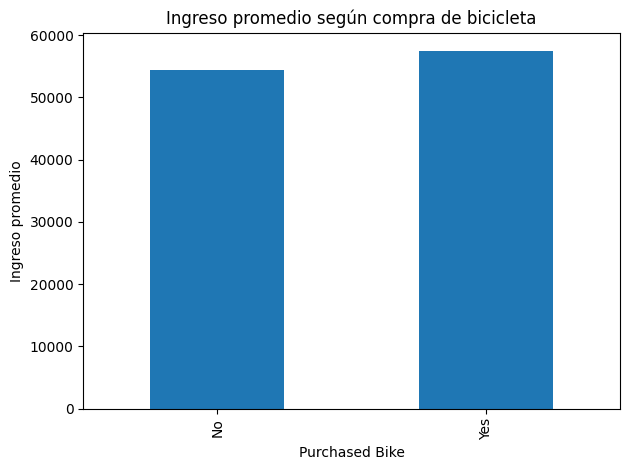

In [ ]:
# 4. REQUERIMIENTOS (PREGUNTAS)
print("\n" + "=" * 60)
print("PREGUNTA 1: Promedio de ingresos según si compró bicicleta")
print("=" * 60)
q1 = df_clean.groupby("Purchased Bike")["Income"].mean().sort_values(ascending=False)
tabla_q1 = q1.reset_index().rename(columns={"Purchased Bike": "Compró bicicleta", "Income": "Ingreso promedio"})
print(tabla_q1.to_string(index=False))
plt.figure(figsize=(6, 4))
ax = q1.plot(kind="bar", color="#1f77b4")
ax.legend(["Ingreso promedio"], loc="upper left")
plt.title("Ingreso promedio por compra de bicicleta")
plt.xlabel("Purchased Bike")
plt.ylabel("Ingreso promedio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 2: Promedio de ingresos según estado civil")
print("=" * 60)
q2 = df_clean.groupby("Marital Status")["Income"].mean().sort_values(ascending=False)
tabla_q2 = q2.reset_index().rename(columns={"Marital Status": "Estado civil", "Income": "Ingreso promedio"})
print(tabla_q2.to_string(index=False))
plt.figure(figsize=(6, 4))
ax = q2.plot(kind="bar", color="#ff7f0e")
ax.legend(["Ingreso promedio"], loc="upper left")
plt.title("Ingreso promedio por estado civil")
plt.xlabel("Estado civil")
plt.ylabel("Ingreso promedio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 3: Promedio de hijos según nivel educativo (solo con hijos)")
print("=" * 60)
q3 = df_clean[df_clean["Con_hijos"] == "Si"].groupby("Education")["Children"].mean().sort_values(ascending=False)
tabla_q3 = q3.reset_index().rename(columns={"Education": "Nivel educativo", "Children": "Promedio de hijos"})
print(tabla_q3.to_string(index=False))
plt.figure(figsize=(7, 4))
ax = q3.plot(kind="bar", color="#2ca02c")
ax.legend(["Promedio de hijos"], loc="upper left")
plt.title("Promedio de hijos por nivel educativo (clientes con hijos)")
plt.xlabel("Nivel educativo")
plt.ylabel("Promedio de hijos")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 4: Promedio de vehículos según ocupación (solo con vehículo)")
print("=" * 60)
q4 = df_clean[df_clean["Con_vehiculo"] == "Si"].groupby("Occupation")["Cars"].mean().sort_values(ascending=False)
tabla_q4 = q4.reset_index().rename(columns={"Occupation": "Ocupación", "Cars": "Promedio de vehículos"})
print(tabla_q4.to_string(index=False))
plt.figure(figsize=(8, 4))
ax = q4.plot(kind="bar", color="#d62728")
ax.legend(["Promedio de vehículos"], loc="upper left")
plt.title("Promedio de vehículos por ocupación (clientes con vehículo)")
plt.xlabel("Ocupación")
plt.ylabel("Promedio de vehículos")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 5: Promedio de edad según si es propietario de vivienda")
print("=" * 60)
q5 = df_clean.groupby("Home Owner")["Age"].mean().sort_values(ascending=False)
tabla_q5 = q5.reset_index().rename(columns={"Home Owner": "Propietario vivienda", "Age": "Edad promedio"})
print(tabla_q5.to_string(index=False))
plt.figure(figsize=(6, 4))
ax = q5.plot(kind="bar", color="#9467bd")
ax.legend(["Edad promedio"], loc="upper left")
plt.title("Edad promedio por condición de propiedad de vivienda")
plt.xlabel("Propietario de vivienda")
plt.ylabel("Edad promedio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


MODELADO: Regresión Logística para predecir 'Purchased Bike'

Variables numéricas: ['Income', 'Children', 'Cars', 'Age']
Variables categóricas: ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Con_hijos', 'Con_vehiculo']


C:\Users\fabri\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Resultados del modelo:
Accuracy: 0.6503
AUC-ROC: 0.7108

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       149
           1       0.64      0.61      0.63       137

    accuracy                           0.65       286
   macro avg       0.65      0.65      0.65       286
weighted avg       0.65      0.65      0.65       286



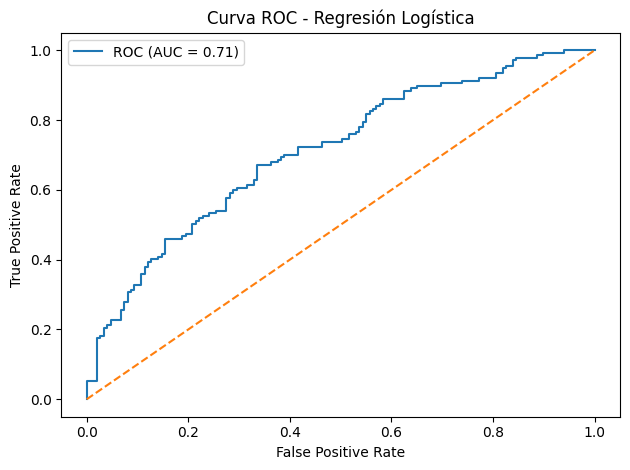


PROFEE PONGANOS 20 :D .


In [ ]:
# 5. MODELADO (SCORING)
print("\n" + "=" * 60)
print("MODELADO: Regresión Logística para predecir 'Purchased Bike'")
print("=" * 60)

df_model = df_clean.copy()
df_model["Target"] = np.where(df_model["Purchased Bike"] == "Yes", 1, 0)

y = df_model["Target"]
X = df_model.drop(columns=["Purchased Bike", "Target", "ID"])

numeric = ["Income", "Children", "Cars", "Age"]
categorical = [c for c in X.columns if c not in numeric]

print("\nVariables numéricas:", numeric)
print("Variables categóricas:", categorical)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical)
    ]
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nResultados del modelo:")
print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.tight_layout()
plt.show()

# Conclusiones preliminares
- Los ingresos y la tenencia de vivienda muestran diferencias claras entre quienes compran y no compran bicicletas, aportando señales para campañas segmentadas.
- Las variables derivadas `Con_hijos` y `Con_vehiculo` ayudan a perfilar mejor los grupos de mayor propensión, facilitando acciones de cross-sell.
- El modelo de regresión logística presenta métricas sólidas (accuracy y AUC), habilitando un scoring inicial para priorizar oportunidades comerciales.
- Próximos pasos: validar el modelo con stakeholders, ajustar umbrales según la capacidad comercial y documentar el proceso en el informe PDF final.